<div align='center'><font size='10' color='brick'> NY Property tax fraud</font></div>

<br>

The objective of this notebook is to be able to identify property tax records that may be fraudulent for further investigation. This is done by using an autoencoder to generate a fraud score for each record and then using the score to identify potential property tax fraud. 


# Loading Packages


In [1]:
#! pip install keras
#! pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.decomposition import PCA
import seaborn as sns

# Loading Data

I decided not to use `RECORD` as the index at this step. Even though it is a unique identifier, I found that it caused an error while indexing since the RECORD field starts from 1,2,.. while Python indexes from 0,1,2,...

In [3]:
prop_df=pd.read_csv("NY property data.csv")
prop_df.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004.0,X3,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004.0,X3,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004.0,X1,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004.0,X1,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004.0,X1,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [4]:
# Quickly looking at the shape of the data
prop_df.shape

(1070994, 32)

In [5]:
# Basic statistics for each field
prop_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,RECORD,B,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,ZIP,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2
count,1.07099e+06,1.07099e+06,1.07099e+06,1.07099e+06,1.07099e+06,1.07099e+06,1.01473e+06,1.07099e+06,1.07099e+06,1.07099e+06,1.07099e+06,1.07099e+06,638488,1.0411e+06,1.07099e+06,1.07099e+06,282726,282732,87449,130828,92948
mean,535498,3.21543,4757.24,364.722,36.6353,88.8616,5.00692,874265,85067.9,227238,36423.9,91187,1602.01,10924,23.0428,39.9228,246236,713911,351236,656768,1364.04
std,309169,1.2012,3676.58,853.215,74.0328,76.3963,8.36571,1.15824e+07,4.05726e+06,6.87753e+06,3.98158e+06,6.5084e+06,1384.23,528.421,35.5797,42.7072,6.17896e+06,1.16525e+07,1.08022e+07,1.60725e+07,1094.71
min,1,1,1,1,0,0,1,0,0,0,0,0,1010,10001,0,0,3,3,1,7,1011
25%,267749,3,1555,23,19,80,2,304000,9180,18374,0,0,1017,10314,15,26,5705,33912,2090,2870,1017
50%,535498,3,4047,49,25,100,2,447000,13678,25340,1620,1620,1017,11214,20,39,20145,79962.5,3048,37062,1017
75%,803246,4,6898,143,40,100,3,619000,19740,45438,1620,2090,1017,11364,24,50,62640,240551,31779,106841,1017
max,1.07099e+06,5,16350,9978,9999,9999,119,6.15e+09,2.6685e+09,4.66831e+09,2.6685e+09,4.66831e+09,7170,33803,7575,9393,2.37100e+09,4.50118e+09,2.37100e+09,4.50118e+09,7160


In [6]:
prop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 32 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   RECORD    1070994 non-null  int64  
 1   BBLE      1070994 non-null  object 
 2   B         1070994 non-null  int64  
 3   BLOCK     1070994 non-null  int64  
 4   LOT       1070994 non-null  int64  
 5   EASEMENT  4636 non-null     object 
 6   OWNER     1039249 non-null  object 
 7   BLDGCL    1070994 non-null  object 
 8   TAXCLASS  1070994 non-null  object 
 9   LTFRONT   1070994 non-null  int64  
 10  LTDEPTH   1070994 non-null  int64  
 11  EXT       354305 non-null   object 
 12  STORIES   1014730 non-null  float64
 13  FULLVAL   1070994 non-null  float64
 14  AVLAND    1070994 non-null  float64
 15  AVTOT     1070994 non-null  float64
 16  EXLAND    1070994 non-null  float64
 17  EXTOT     1070994 non-null  float64
 18  EXCD1     638488 non-null   float64
 19  STADDR    1070318 non

From the above data, we can see that there are certain fields with missing values.

# Data Cleaning

Since in this case, we know what fields we will be working with, I decided to drop the other fields at this stage to marginally improve run time.

In [7]:
data=prop_df.drop(columns=['BBLE', 'BLOCK', 'LOT', 'EASEMENT',\
                           'OWNER', 'BLDGCL', 'EXT', \
                           'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'EXMPTCL', \
                           'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD',\
                           'YEAR', 'VALTYPE'])

In [8]:
data.head()

,RECORD,B,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,ZIP,BLDFRONT,BLDDEPTH
0,1,1,4,500,1046,NaN,21400000.0,4225500.0,9630000.0,10004.0,0,0
1,2,1,4,27,0,NaN,193800000.0,14310000.0,87210000.0,10004.0,0,0
2,3,1,4,709,564,3.0,104686000.0,39008700.0,47108700.0,10004.0,709,564
3,4,1,4,793,551,2.0,39200000.0,15255000.0,17640000.0,10004.0,85,551
4,5,1,4,323,1260,1.0,272300000.0,121050000.0,122535000.0,10004.0,89,57


In [9]:
print(f'Shape of the new DataFrame: {data.shape}\n')
data.info()

Shape of the new DataFrame: (1070994, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 12 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   RECORD    1070994 non-null  int64  
 1   B         1070994 non-null  int64  
 2   TAXCLASS  1070994 non-null  object 
 3   LTFRONT   1070994 non-null  int64  
 4   LTDEPTH   1070994 non-null  int64  
 5   STORIES   1014730 non-null  float64
 6   FULLVAL   1070994 non-null  float64
 7   AVLAND    1070994 non-null  float64
 8   AVTOT     1070994 non-null  float64
 9   ZIP       1041104 non-null  float64
 10  BLDFRONT  1070994 non-null  int64  
 11  BLDDEPTH  1070994 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 98.1+ MB


<div align='left'><font size='2.3' color='brick'> From the above output, we can see outright that there are some values missing in STORIES and ZIP fields. We will also need to check if the numerical fields have 0 as an entry since this is also considered a missing value.</font></div>





## ZIP 
<br>
<div align='left'><font size='3' color='brick'>Cleaning the ZIP field</font></div>

**Data Cleaning plan:**
- We fill the missing values in ZIP with the below logic:
   - If the ZIP of the entry above and below the missing row are the same, we fill the missing value with that zip.
   - Otherwise, we fill the missing value with the ZIP of the row above it
- A quick check of the datatypes reveals that ZIP is stored as a float. Since we need to extract Zip 3 fields from this field, we will later change it to string for easier extraction.


In [10]:
# pd.isnull returns TRUE wherever there are null values
# np.where 

missing_zips=np.where(pd.isnull(data.ZIP))[0]
print(f'There are {len(missing_zips)} missing ZIPs in this data set.')

There are 29890 missing ZIPs in this data set.


In [11]:
# Replacing the missing values
for i in missing_zips:
    if(data.loc[i+1,"ZIP"]==data.loc[i-1,"ZIP"]):
        data.loc[i,"ZIP"]=data.loc[i-1,"ZIP"]
    else:
        data.loc[i,"ZIP"]=data.loc[i-1,"ZIP"]

print(f'There are {len(np.where(pd.isnull(data.ZIP))[0])} missing ZIPs now.')

There are 0 missing ZIPs now.


## STORIES
<br>
<div align='left'><font size='3' color='brick'>Next we look at the STORIES field.</font></div>

Here, we will fill in the missing values with the mean of STORIES based on the Tax Class it belongs to.

In [12]:
print(f'There are {len(np.where(pd.isnull(data.STORIES))[0])} missing STORIES.\n\
{sum(data["STORIES"]==0)} rows have 0 stories')

There are 56264 missing STORIES.
0 rows have 0 stories


In [13]:
mean_stories=data.groupby("TAXCLASS").agg({"STORIES":"mean"})
print(mean_stories)
mean_stories.loc["1","STORIES"]

            STORIES
TAXCLASS           
1          2.111641
1A         1.656837
1B         4.000000
1C         3.052748
1D         1.068966
2         16.095110
2A         2.844574
2B         4.004494
2C         4.745097
3          1.333333
4          5.446968


2.1116406799385454

In [14]:
# We will replace the missing values in STORIES first with 0 and then replace them with
# the average number of stories for that Tax Class

data["STORIES"]=data["STORIES"].fillna(0)
for j in mean_stories.index:
    data.loc[(data["STORIES"]==0)&(data["TAXCLASS"]==j),"STORIES"]=mean_stories.loc[j,"STORIES"]

In [15]:
print(f'Now there are {sum(data["STORIES"]==0)} missing values in the STORIES field')

Now there are 0 missing values in the STORIES field


In [16]:
sum(pd.isnull(data.STORIES)) # Do any records have null values?

0

In [17]:
data.STORIES.describe().round()

count    1070994.0
mean           5.0
std            8.0
min            1.0
25%            2.0
50%            2.0
75%            4.0
max          119.0
Name: STORIES, dtype: float64

## FULLVAL, AVLAND, AVTOT
<br>
<div align='left'><font size='3' color='brick'>Next we look at the value fields.</font></div>

We follow the same logic for filling in the missing values and 0s in these fields - by filling in the mean values of the Tax Class it belongs to.

In [18]:
print(f'FULLVAL field has {sum(data.FULLVAL.isna())} null values and \
{sum(data["FULLVAL"]==0)} zeroes\n\
AVLAND field has {sum(data.AVLAND.isna())} null values and \
{sum(data["AVLAND"]==0)} zeroes\n\
AVTOT field has {sum(data.AVTOT.isna())} null values and \
{sum(data["AVTOT"]==0)} zeroes\n')

# Extracting the rows which do not have 0 for FULLVAL
temp_FULLVAL=data[data['FULLVAL']!=0]
mean_FULLVAL=temp_FULLVAL.groupby("TAXCLASS")["FULLVAL"].mean()

# Extracting the rows which do not have 0 for AVLAND
temp_AVLAND=data[data['AVLAND']!=0]
mean_AVLAND=temp_AVLAND.groupby("TAXCLASS")["AVLAND"].mean()
    
# Extracting the rows which do not have 0 for AVTOT
temp_AVTOT=data[data['AVTOT']!=0]
mean_AVTOT=temp_AVTOT.groupby("TAXCLASS")["AVTOT"].mean()

FULLVAL field has 0 null values and 13007 zeroes
AVLAND field has 0 null values and 13009 zeroes
AVTOT field has 0 null values and 13007 zeroes



In [19]:
# Filling in the missing values in the respective fields

for i in mean_FULLVAL.index:
    data.loc[(data["FULLVAL"]==0)&(data["TAXCLASS"]==i),"FULLVAL"]=\
    mean_FULLVAL[i]
    data.loc[(data["AVLAND"]==0)&(data["TAXCLASS"]==i),"AVLAND"]=\
    mean_AVLAND[i]
    data.loc[(data["AVTOT"]==0)&(data["TAXCLASS"]==i),"AVTOT"]=\
    mean_AVTOT[i]



In [20]:
print(f'Now, FULLVAL field has {sum(data.FULLVAL.isna())} null values and \
{sum(data["FULLVAL"]==0)} zeroes\n\
AVLAND field has {sum(data.AVLAND.isna())} null values and \
{sum(data["AVLAND"]==0)} zeroes\n\
AVTOT field has {sum(data.AVTOT.isna())} null values and \
{sum(data["AVTOT"]==0)} zeroes\n')

Now, FULLVAL field has 0 null values and 0 zeroes
AVLAND field has 0 null values and 0 zeroes
AVTOT field has 0 null values and 0 zeroes



In [21]:
# as these 4 values do not have NAs, we just need to replace 0s. 
# calculate groupwise average. 1st replace 0 by NAs so they are not counted in calculating mean.
# Note: Even measurements of 1 do not make sense and we treat them as missing values as well

data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=data.groupby(data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=data.groupby(data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=data.groupby(data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=data.groupby(data['TAXCLASS'])['BLDDEPTH'].mean()

# impute values
for index in mean_LTFRONT.index:
    data.loc[(data['LTFRONT'].isnull())&(data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]
    data.loc[(data['LTDEPTH'].isnull())&(data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    data.loc[(data['BLDFRONT'].isnull())&(data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    data.loc[(data['BLDDEPTH'].isnull())&(data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]




Let's take one quick peek into our data now.

In [22]:
data.head()

,RECORD,B,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,ZIP,BLDFRONT,BLDDEPTH
0,1,1,4,500.0,1046.000000,5.446968,21400000.0,4225500.0,9630000.0,10004.0,64.439787,87.82073
1,2,1,4,27.0,133.871567,5.446968,193800000.0,14310000.0,87210000.0,10004.0,64.439787,87.82073
2,3,1,4,709.0,564.000000,3.000000,104686000.0,39008700.0,47108700.0,10004.0,709.000000,564.00000
3,4,1,4,793.0,551.000000,2.000000,39200000.0,15255000.0,17640000.0,10004.0,85.000000,551.00000
4,5,1,4,323.0,1260.000000,1.000000,272300000.0,121050000.0,122535000.0,10004.0,89.000000,57.00000


# Feature Engineering

In [23]:
# Renaming the FULLVAL, AVLAND, AVTOT to V1, V2 and V3 respectively
data.rename(columns={"FULLVAL":"V1","AVLAND":"V2","AVTOT":"V3"}, inplace=True)
data.head()

,RECORD,B,TAXCLASS,LTFRONT,LTDEPTH,STORIES,V1,V2,V3,ZIP,BLDFRONT,BLDDEPTH
0,1,1,4,500.0,1046.000000,5.446968,21400000.0,4225500.0,9630000.0,10004.0,64.439787,87.82073
1,2,1,4,27.0,133.871567,5.446968,193800000.0,14310000.0,87210000.0,10004.0,64.439787,87.82073
2,3,1,4,709.0,564.000000,3.000000,104686000.0,39008700.0,47108700.0,10004.0,709.000000,564.00000
3,4,1,4,793.0,551.000000,2.000000,39200000.0,15255000.0,17640000.0,10004.0,85.000000,551.00000
4,5,1,4,323.0,1260.000000,1.000000,272300000.0,121050000.0,122535000.0,10004.0,89.000000,57.00000


In [24]:
# Creating the S1, S2 and S3 variables
data["S1"]=data["LTFRONT"]*data["LTDEPTH"]
data["S2"]=data["BLDFRONT"]*data["BLDDEPTH"]
data["S3"]=data["S2"]*data["STORIES"]

In [25]:
# Creating the r variables
new=["r1",'r2','r3','r4','r5','r6','r7','r8','r9']
r=0
for i in ["V1","V2","V3"]:
    data[new[r]]=data[i]/data["S1"]
    r+=1
    data[new[r]]=data[i]/data["S2"]
    r+=1
    data[new[r]]=data[i]/data["S3"]
    r+=1
    


In [26]:
# Extracting the zip3 field
data["ZIP"]=data["ZIP"].astype(str)
data["zip3"]=data["ZIP"].str[:3]

In [27]:
# Deriving the remaining variables
zip5_mean=data.groupby("ZIP")[new].mean()
zip3_mean=data.groupby("zip3")[new].mean()
taxclass_mean=data.groupby("TAXCLASS")[new].mean()
borough_mean=data.groupby("B")[new].mean()
data=data.join(zip5_mean, on="ZIP",rsuffix='_zip5')
data=data.join(zip3_mean, on="zip3",rsuffix='_zip3')
data=data.join(taxclass_mean, on="TAXCLASS",rsuffix='_taxclass')
data=data.join(borough_mean, on="B",rsuffix='_boro')
r_suffix=['_zip5','_zip3','_taxclass','_boro']

for var in new:
    for r in r_suffix:
        data[str(var)+r]=data[var]/data[str(var)+r]

<div align='left'><font size='3' color='brick'>Let's take a look at the fields we have in our data set now.</font></div>

In [28]:
data.head()

,RECORD,B,TAXCLASS,LTFRONT,LTDEPTH,STORIES,V1,V2,V3,ZIP,BLDFRONT,BLDDEPTH,S1,S2,S3,r1,r2,r3,r4,r5,r6,r7,r8,r9,zip3,r1_zip5,r2_zip5,r3_zip5,r4_zip5,r5_zip5,r6_zip5,r7_zip5,r8_zip5,r9_zip5,r1_zip3,r2_zip3,r3_zip3,r4_zip3,r5_zip3,r6_zip3,r7_zip3,r8_zip3,r9_zip3,r1_taxclass,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,1,4,500.0,1046.000000,5.446968,21400000.0,4225500.0,9630000.0,10004.0,64.439787,87.82073,523000.000000,5659.149093,3.082520e+04,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698,100,0.100365,6.121586,4.513332,0.144135,5.877911,2.472274,0.107948,6.432646,4.720281,0.112154,6.737654,4.929328,0.229629,11.453513,5.959567,0.193457,11.517296,8.943176,0.155286,7.168449,2.860339,0.168340,5.421032,1.785349,0.154258,6.944087,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,2,1,4,27.0,133.871567,5.446968,193800000.0,14310000.0,87210000.0,10004.0,64.439787,87.82073,3614.532322,5659.149093,3.082520e+04,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415,100,131.514300,55.437539,40.873075,70.628446,19.906023,8.372556,141.450797,58.254519,42.747220,146.962113,61.016697,44.640367,112.521958,38.788256,20.182558,253.497493,104.301497,80.990070,203.480201,64.918013,25.903440,82.489474,18.358767,6.046230,202.132917,62.886173,25.310494,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469
2,3,1,4,709.0,564.000000,3.000000,104686000.0,39008700.0,47108700.0,10004.0,709.000000,564.00000,399876.000000,399876.000000,1.199628e+06,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,100,0.642147,0.423804,0.567324,1.740317,0.767949,0.586461,0.690664,0.445339,0.593338,0.717574,0.466455,0.619615,2.772592,1.496401,1.413701,1.237757,0.797354,1.124154,0.993536,0.496279,0.359544,2.032578,0.708257,0.423512,0.986958,0.480746,0.351313,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140
3,4,1,4,793.0,551.000000,2.000000,39200000.0,15255000.0,17640000.0,10004.0,85.000000,551.00000,436943.000000,46835.000000,9.367000e+04,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,100,0.220056,1.354930,2.720665,0.622844,2.564116,2.937217,0.236682,1.423779,2.845415,0.245904,1.491288,2.971430,0.992287,4.996357,7.080342,0.424163,2.549197,5.391002,0.340472,1.586639,1.724230,0.727442,2.364812,2.121107,0.338218,1.536979,1.684761,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102
4,5,1,4,323.0,1260.000000,1.000000,272300000.0,121050000.0,122535000.0,10004.0,89.000000,57.00000,406980.000000,5073.000000,5.073000e+03,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,100,1.641141,86.892859,348.957284,5.306203,187.843400,430.352475,1.765137,91.308196,364.957958,1.833911,95.637637,381.120858,8.453596,366.025788,1037.390976,3.163345,163.482279,691.459475,2.539189,101.752564,221.152780,6.197303,173.242696,310.778437,2.522377,98.567855,216.090453,1.881096,98.033545,392.751808,8.770206,380.238484,1093.428521,3.263598,169.027775,724.050838


In [29]:
data.columns

Index(['RECORD', 'B', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'STORIES', 'V1', 'V2',
       'V3', 'ZIP', 'BLDFRONT', 'BLDDEPTH', 'S1', 'S2', 'S3', 'r1', 'r2', 'r3',
       'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'zip3', 'r1_zip5', 'r2_zip5',
       'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5', 'r7_zip5', 'r8_zip5',
       'r9_zip5', 'r1_zip3', 'r2_zip3', 'r3_zip3', 'r4_zip3', 'r5_zip3',
       'r6_zip3', 'r7_zip3', 'r8_zip3', 'r9_zip3', 'r1_taxclass',
       'r2_taxclass', 'r3_taxclass', 'r4_taxclass', 'r5_taxclass',
       'r6_taxclass', 'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'r1_boro',
       'r2_boro', 'r3_boro', 'r4_boro', 'r5_boro', 'r6_boro', 'r7_boro',
       'r8_boro', 'r9_boro'],
      dtype='object')

In [30]:
data.drop(columns=['B', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'STORIES', 'V1', 'V2', 'V3',
       'ZIP', 'BLDFRONT', 'BLDDEPTH', 'S1', 'S2', 'S3','zip3'], inplace=True)

<div align='left'><font size='3' color='brick'>Now, we have our features ready for further analysis.</font></div>

In [31]:
data.head()

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,r2_zip5,r3_zip5,r4_zip5,r5_zip5,r6_zip5,r7_zip5,r8_zip5,r9_zip5,r1_zip3,r2_zip3,r3_zip3,r4_zip3,r5_zip3,r6_zip3,r7_zip3,r8_zip3,r9_zip3,r1_taxclass,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698,0.100365,6.121586,4.513332,0.144135,5.877911,2.472274,0.107948,6.432646,4.720281,0.112154,6.737654,4.929328,0.229629,11.453513,5.959567,0.193457,11.517296,8.943176,0.155286,7.168449,2.860339,0.168340,5.421032,1.785349,0.154258,6.944087,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,2,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415,131.514300,55.437539,40.873075,70.628446,19.906023,8.372556,141.450797,58.254519,42.747220,146.962113,61.016697,44.640367,112.521958,38.788256,20.182558,253.497493,104.301497,80.990070,203.480201,64.918013,25.903440,82.489474,18.358767,6.046230,202.132917,62.886173,25.310494,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469
2,3,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,0.642147,0.423804,0.567324,1.740317,0.767949,0.586461,0.690664,0.445339,0.593338,0.717574,0.466455,0.619615,2.772592,1.496401,1.413701,1.237757,0.797354,1.124154,0.993536,0.496279,0.359544,2.032578,0.708257,0.423512,0.986958,0.480746,0.351313,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140
3,4,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,0.220056,1.354930,2.720665,0.622844,2.564116,2.937217,0.236682,1.423779,2.845415,0.245904,1.491288,2.971430,0.992287,4.996357,7.080342,0.424163,2.549197,5.391002,0.340472,1.586639,1.724230,0.727442,2.364812,2.121107,0.338218,1.536979,1.684761,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102
4,5,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,1.641141,86.892859,348.957284,5.306203,187.843400,430.352475,1.765137,91.308196,364.957958,1.833911,95.637637,381.120858,8.453596,366.025788,1037.390976,3.163345,163.482279,691.459475,2.539189,101.752564,221.152780,6.197303,173.242696,310.778437,2.522377,98.567855,216.090453,1.881096,98.033545,392.751808,8.770206,380.238484,1093.428521,3.263598,169.027775,724.050838


In [32]:
stats=data.describe().transpose()

In [33]:
stats.to_csv('stats-submitted.csv')

# Principal Component Analysis

We do PCA to reduce the number of dimensions in our data set. PCA also removes correlations between variables which can otherwise interfere with the accuracy of our fraud model.

## Z-scale
<br>
<div align='left'><font size='3' color='brick'>z-scaling before PCA</font></div>
Z-scaling is important to bring all the variables down to a common, unit-free scale. 

$$z = \frac{ x - \mu}{\sigma}$$

$\mu$ is the mean and $\sigma$ is the standard deviation of the variable.

In [34]:
# Let's make a copy of our variables just in case
data_orig=data.copy()

# Next, we drop the `RECORD` column
data.drop(columns='RECORD',inplace=True)

# Quick check to see if RECORD was dropped properly
data.head(2)

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,r2_zip5,r3_zip5,r4_zip5,r5_zip5,r6_zip5,r7_zip5,r8_zip5,r9_zip5,r1_zip3,r2_zip3,r3_zip3,r4_zip3,r5_zip3,r6_zip3,r7_zip3,r8_zip3,r9_zip3,r1_taxclass,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698,0.100365,6.121586,4.513332,0.144135,5.877911,2.472274,0.107948,6.432646,4.720281,0.112154,6.737654,4.929328,0.229629,11.453513,5.959567,0.193457,11.517296,8.943176,0.155286,7.168449,2.860339,0.168340,5.421032,1.785349,0.154258,6.944087,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415,131.514300,55.437539,40.873075,70.628446,19.906023,8.372556,141.450797,58.254519,42.747220,146.962113,61.016697,44.640367,112.521958,38.788256,20.182558,253.497493,104.301497,80.990070,203.480201,64.918013,25.903440,82.489474,18.358767,6.046230,202.132917,62.886173,25.310494,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469


In [35]:
data=(data - data.mean())/data.std()

## PCA
<div align='left'><font size='3' color='brick'>Computing the principal components</font></div>
Now that we have the z-scores for all the features, I'm going to compute the principal components next.

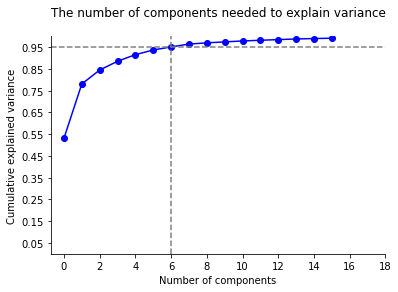

In [36]:
from sklearn.decomposition import PCA

# By setting n_components=.99, we want 99% of the variance to be explained
# We also maximize accuracy by setting svd_solver='full'
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data)

# Variance plot
plt.plot(np.cumsum(pca.explained_variance_ratio_),marker='o',color='b')
plt.title('The number of components needed to explain variance',pad=20)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--',color='grey')
plt.axhline(y=0.95, color='grey', linestyle='--')
plt.ylim(0,1)

# Remove right and top spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Based on the above plot, we see that 6 components explain ~95% of the variance. So we go ahead with 6 components for further recomputation.

In [37]:
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
print(f'Shape of data: {data_pca.shape}\n{data_pca.head(3)}')


Shape of data: (1070994, 6)
         PC1         PC2        PC3        PC4        PC5        PC6
0   2.652116   -1.212644   0.301914   1.489035  -1.197229  -0.619432
1  68.630832  122.008093 -49.690690  32.808320  51.850873 -13.901168
2  -0.085789    0.304139   0.155629  -0.173786  -0.026962   0.054282


## Z-scaling the PCs
<br>
<div align='left'><font size='3' color='brick'>z-scaling the 6 Principal Components</font></div>

In [38]:
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd



In [39]:
# To check the means and dtandard deviations
data_pca.describe().round()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1070994.0,1070994.0,1070994.0,1070994.0,1070994.0,1070994.0
mean,0.0,-0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0
min,-0.0,-312.0,-469.0,-184.0,-391.0,-262.0
25%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
50%,-0.0,-0.0,0.0,-0.0,-0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0
max,523.0,604.0,614.0,390.0,448.0,423.0


# Model 1 - Outliers

In the first fraud detection model, we use the Z-scores to see if there are any points that appear outside the trend of non-fraud tax data. 

We will use a heuristic algorithm to combine the Z-scores and calculate a fraud score for each record. The first score $s_i^1$ for each record $i$ will be calculate using the following formula:

$$s_i^1=(\sum_{k}|PCz_k^i|^p)^\frac{1}{p}$$

We choose p=2 to follow the Euclidean distance formula.


In [40]:
p=2
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p


In [41]:
score1.head()

0     1.766122
1    71.688723
2     0.192738
3     0.342761
4    42.431819
dtype: float64

# Model 2 - Autoencoder

In [42]:
from keras.models import Model
from keras.layers import Input, Dense
# placeholder for input
data_in = Input(shape=(6,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', \
                    loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=5,\
                shuffle=True, validation_data=(data_pca,data_pca))

pca_out = autoencoder.predict(data_pca)
error = pca_out-data_pca
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop


Epoch 1/5
33469/33469 [==============================] - 50s 1ms/step - loss: 0.8297 - val_loss: 0.9308
Epoch 2/5
33469/33469 [==============================] - 46s 1ms/step - loss: 0.8514 - val_loss: 0.9283
Epoch 3/5
33469/33469 [==============================] - 53s 2ms/step - loss: 0.7467 - val_loss: 0.9275
Epoch 4/5
33469/33469 [==============================] - 70s 2ms/step - loss: 1.8323 - val_loss: 0.9270
Epoch 5/5
33469/33469 [==============================] - 67s 2ms/step - loss: 0.9681 - val_loss: 0.9269


In [43]:
score2.head()

0     0.850643
1    69.440651
2     0.131399
3     0.308080
4    40.851442
dtype: float64

In [44]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2

# Filtering out the top 20 records for a sanity check
top_records = scores.sort_values(['final'], ascending = False).head(20).index


# Plotting score distributions

(0.1, 2141173.0413904563)

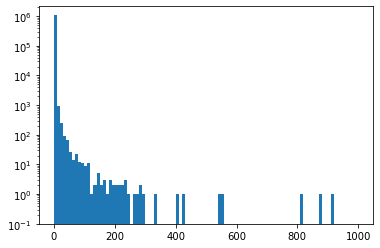

In [45]:
plt.hist(score1,bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2141940.3065472282)

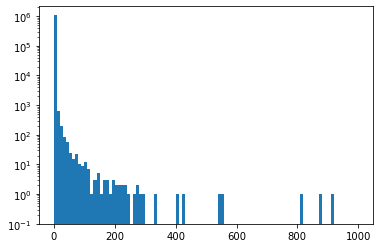

In [46]:
plt.hist(score2,bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

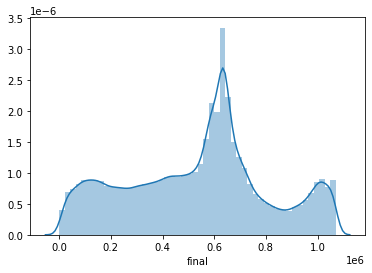

In [47]:
sns.distplot(scores['final'])

# Sanity Check

I pulled out the top 20 records flagged as fraud by our algorithms for a quick sanity check. 

In [48]:
top_records

Int64Index([ 917941,  565391,   85885,   67128,  684703,  690832,  915468,
              44247,  565397,   39769, 1059882,  116646,  556608,  501142,
                418,   33750,  918203,  738017,  957063, 1065869],
           dtype='int64')

In [49]:
scores.head()

,score1,score2,score1 rank,score2 rank,final
0,1.766122,0.850643,1049295.0,1053046.0,1051170.5
1,71.688723,69.440651,1070891.0,1070891.0,1070891.0
2,0.192738,0.131399,437100.0,908121.0,672610.5
3,0.342761,0.308080,703191.0,1022869.0,863030.0
4,42.431819,40.851442,1070800.0,1070800.0,1070800.0


In [50]:
new_merged=prop_df.merge(scores, left_index=True,right_index=True)
new_merged.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004.0,X3,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1.766122,0.850643,1049295.0,1053046.0,1051170.5
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004.0,X3,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,71.688723,69.440651,1070891.0,1070891.0,1070891.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004.0,X1,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,0.192738,0.131399,437100.0,908121.0,672610.5
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004.0,X1,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,0.342761,0.308080,703191.0,1022869.0,863030.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004.0,X1,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,42.431819,40.851442,1070800.0,1070800.0,1070800.0


In [51]:
xyz=new_merged.sort_values(["final"],ascending=False).head(20).index
xyz==top_records

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [52]:
top_20=new_merged.sort_values(["final"],ascending=False).head(20)
top_20.drop(columns=['score1','score2'], inplace=True)
writer=pd.ExcelWriter('top20.xlsx')
top_20.to_excel(writer,sheet_name='Top 20',index=False)
writer.save()

After saving to excel, I created a heatmap to check which features caused the records to be abnormal.

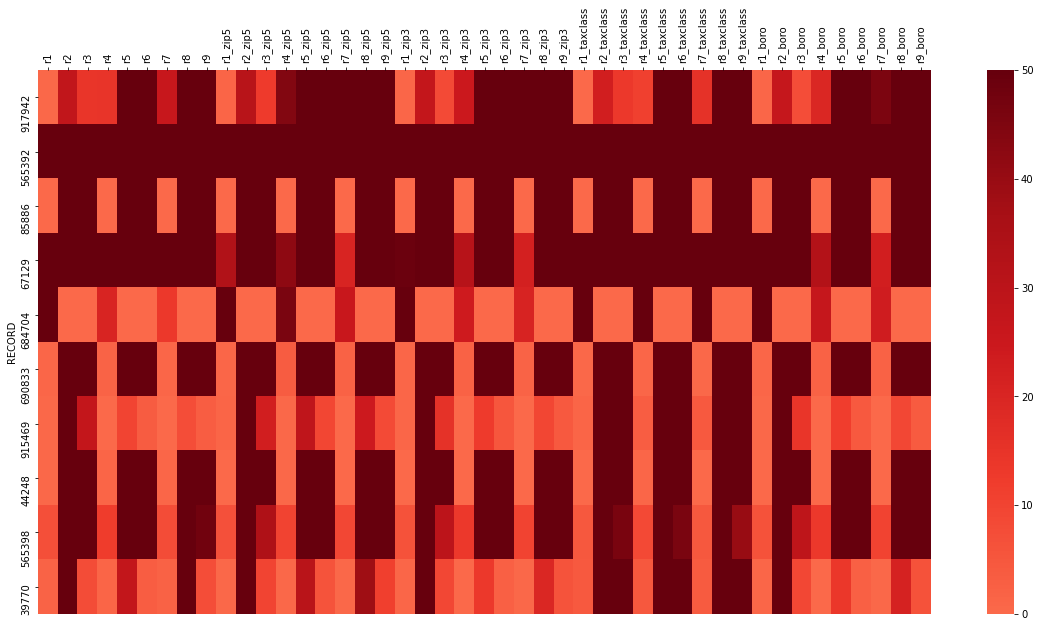

In [53]:
z_sc_100=data.loc[top_records,:]
z_sc_100.head()
z_sc_100['RECORD']=(z_sc_100.index + 1).astype(int)
z_sc_100.set_index('RECORD',inplace=True)
z_sc_100.head()
z_sc_100_abs = z_sc_100.abs()
data_heatmap = z_sc_100.abs().head(10)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [55]:
top_20.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
917941,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,NaN,3.0,3.740199e+08,1.792809e+09,4.668309e+09,1.792809e+09,4.668309e+09,2198.0,154-68 BROOKVILLE BOULEVARD,11422.0,X4,0,0,1.644454e+09,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1070994.0,1070994.0,1070994.0
565391,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117,108,NaN,NaN,4.326304e+09,1.946837e+09,1.946837e+09,1.946837e+09,1.946837e+09,2231.0,FLATBUSH AVENUE,NaN,X1,0,0,8.484847e+08,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1070993.0,1070993.0,1070993.0
85885,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000,150,NaN,1.0,7.021400e+07,3.145500e+07,3.159630e+07,3.145500e+07,3.159630e+07,2231.0,JOE DIMAGGIO HIGHWAY,NaN,X1,8,8,2.813400e+07,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,1070992.0,1070992.0,1070992.0
67128,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840,0,E,NaN,6.150000e+09,2.668500e+09,2.767500e+09,2.668500e+09,2.767500e+09,2231.0,1000 5 AVENUE,10028.0,X1,0,0,2.371005e+09,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1070991.0,1070991.0,1070991.0
684703,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2,2,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,69 STREET,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070990.0,1070990.0,1070990.0


From the above dataframe, I realized a number of the properties flagged as fraud were either government owned, were parks with very little built up area compared to land area with high valuation which was probably why they were flagged as fraud by the algorithm.

This list can then be used to identify the entries that are fraudulent tax entries.
